# **CII Models - Return models**

Review:
- Return is close to normal distribution with somewhat heavy tails.
- Return is stationary (both unit root and trend).
- There is volatility clustering (High autocorrelation in squared return)
- There is momentum (High autocorrelation in return lag 1)

#### **I. Imports and Load**

In [1]:
# Imports
# General
import numpy as np
import pandas as pd
import datetime
import math
import os
import sys
import random

# Preprocess

# Models
import statsmodels.api as sm
#from sklearn.model_selection import cross_val_score
from sklearn.metrics import root_mean_squared_error
#import tensorflow as tf

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Utils
sys.path.append(os.path.abspath('..'))
from src.utils.get_data import get_stock
from src.metrics.risk import qlike
from src.preprocess.data_transform import make_lags, make_shocks
from src.preprocess.split import purge_kfold_split
from src.models.risk import ARCH_MD, GARCH_MD
from src.models.decision import price_volatility

d:\workplace\Project\stock_analyst\sa_env\Lib\site-packages\vnai\scope\profile.py:562: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
# Configs
np.random.seed(42)
#tf.random.set_seed(42)
NUM_DAYS_YEAR = 252
START_DATE = '2007-01-01'
END_DATE = '2025-09-01'
#END_DATE = datetime.datetime.now().strftime('%Y-%m-%d')

In [3]:
# Load data
df = get_stock('CII', START_DATE, END_DATE)
df.shape

(4650, 8)

#### **II. Preprocess**

In [4]:
# Add squared return
df['squared_return'] = df['return']**2
df.head(1)

,time,open,high,low,close,volume,return,log_return,squared_return
1,2007-01-03,8.17,8.33,8.17,8.33,132630,0.012151,0.012077,0.000148


In [5]:
df.reset_index(inplace=True)
df.head(1)

,index,time,open,high,low,close,volume,return,log_return,squared_return
0,1,2007-01-03,8.17,8.33,8.17,8.33,132630,0.012151,0.012077,0.000148


#### **III. Choosing metrics**

- For return model: 
  + The return distribution is fat tailed with a few extreme value but meaningful, use MAE so the extreme value does not overwhelm the evaluation while still keep somewhat of it information.
  + RMSE good for large mistake (risk management) but may not be stable or driven toward extreme values.
  + Also evaluate direction accuracy of the model, since the return is highly close to 0 most of the time and so is the mean, direction would be a good differentiate when MAE can not estimate between close but wrong signs true and predicted value.  
  => Since sign estimating is important, and mean is close to 0, RMSE would be bad since it penalizes extreme value misprediction and may drive the whole evaluation toward it. This lead to possible bias result toward negative or postive (whichever has larger extreme values).  
  => To evaluate return model: MAE + direction accuracy

- For votality model:
  + QLike
  + Log-likelihood for select GARCH models.

#### **IV. Return models**

- Modeling return is inappropriate, this is true due to unmet assumptions.

#### **V. Volatility models**

0. Baseline

In [6]:
var_bl = df['return'].std()**2

In [7]:
bl_loss = qlike(df['return'].iloc[3000:], var_bl)
bl_loss

np.float64(3.042921245234703)

1. ARCH(q)

In [8]:
# Configs
q = 10
lr = 0.0000001
epochs = 1000

In [9]:
# ARCH - manually derived
train_loss_list1 = []
val_loss_list1 = []
fold = 1

for train_idx, test_idx in purge_kfold_split(df['return'], n_splits=3, embargo=0.01): 
    train, test = df['return'][train_idx], df['return'][test_idx]
    arch_01 = ARCH_MD(q, epochs, lr)
    arch_01.fit(returns=train, validation=test, stopstep=5)
    
    train_loss = arch_01.train_loss[-1]
    val_loss = arch_01.val_loss[-1]
    train_loss_list1.append(train_loss)
    val_loss_list1.append(val_loss)

print(f'Train loss: {np.asarray(train_loss_list1).mean():.2f} - Val loss: {np.asarray(val_loss_list1).mean():.2f}')

Train loss: 1.84 - Val loss: 0.98


In [10]:
# ARCH log - manually derived
train_loss_list2 = []
val_loss_list2 = []
fold = 1

for train_idx, test_idx in purge_kfold_split(df['return'], n_splits=3, embargo=0.01): 
    train, test = df['return'][train_idx], df['return'][test_idx]
    arch_02 = ARCH_MD(q, epochs, lr, log='log')
    arch_02.fit(returns=train, validation=test, stopstep=5)
    
    train_loss = arch_02.train_loss[-1]
    val_loss = arch_02.val_loss[-1]
    train_loss_list2.append(train_loss)
    val_loss_list2.append(val_loss)

print(f'Train loss: {np.asarray(train_loss_list2).mean():.2f} - Val loss: {np.asarray(val_loss_list2).mean():.2f}')

Train loss: 2.07 - Val loss: 1.32


In [11]:
# ARCH hybrid - manually derived
train_loss_list3 = []
val_loss_list3 = []
fold = 1

for train_idx, test_idx in purge_kfold_split(df['return'], n_splits=3, embargo=0.01): 
    train, test = df['return'][train_idx], df['return'][test_idx]
    arch_03 = ARCH_MD(q, epochs, lr=0.00001, log='hybrid')
    arch_03.fit(returns=train, validation=test, stopstep=5)
    
    train_loss = arch_03.train_loss[-1]
    val_loss = arch_03.val_loss[-1]
    train_loss_list3.append(train_loss)
    val_loss_list3.append(val_loss)

print(f'Train loss: {np.asarray(train_loss_list3).mean():.2f} - Val loss: {np.asarray(val_loss_list3).mean():.2f}')

Train loss: 1.94 - Val loss: 0.86


In [12]:
# ARCH - scipy optimizer

In [13]:
# ARCH - auto differential

In [14]:
coefs = arch_02.summary()
coefs.head(7)

,coef value
lag2,0.123648
lag1,0.101885
lag5,0.095060
lag10,0.075942
lag4,0.072659
lag3,0.072412
lag6,0.058685


Text(0.5, 0, 'Coef value')

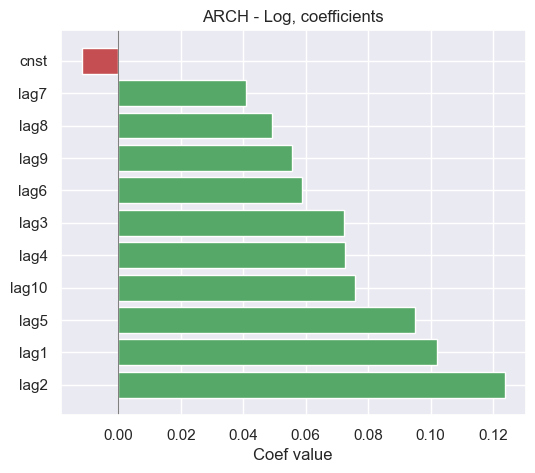

In [15]:
plt.figure(figsize=(6, 5))
colors = ['g' if c > 0 else 'r' for c in coefs['coef value']]
plt.barh(y=coefs.index, width=coefs['coef value'], color=colors)
plt.title("ARCH - Log, coefficients")
plt.axvline(0, color='grey', linewidth=0.8)
plt.xlabel('Coef value')

2.  GARCH(p, q)

In [16]:
# Configs
p = 8
q = 10
epochs = 1000 
lr = 0.00001

In [17]:
# GARCH - manually derived
train_loss_list4 = []
val_loss_list4 = []
fold = 1

for train_idx, test_idx in purge_kfold_split(df['return'], n_splits=3, embargo=0.01): 
    train, test = df['return'][train_idx], df['return'][test_idx]
    garch_01 = GARCH_MD(q, p, epochs, lr)
    garch_01.fit(returns=train, validation=test, stopstep=5)
    
    train_loss = garch_01.train_loss[-1]
    val_loss = garch_01.val_loss[-1]
    train_loss_list4.append(train_loss)
    val_loss_list4.append(val_loss)

print(f'Train loss: {np.asarray(train_loss_list4).mean():.2f} - Val loss: {np.asarray(val_loss_list4).mean():.2f}')

Train loss: 2.15 - Val loss: 0.73


In [18]:
garch_coef = garch_01.summary()

Text(0.5, 0, 'Coef value')

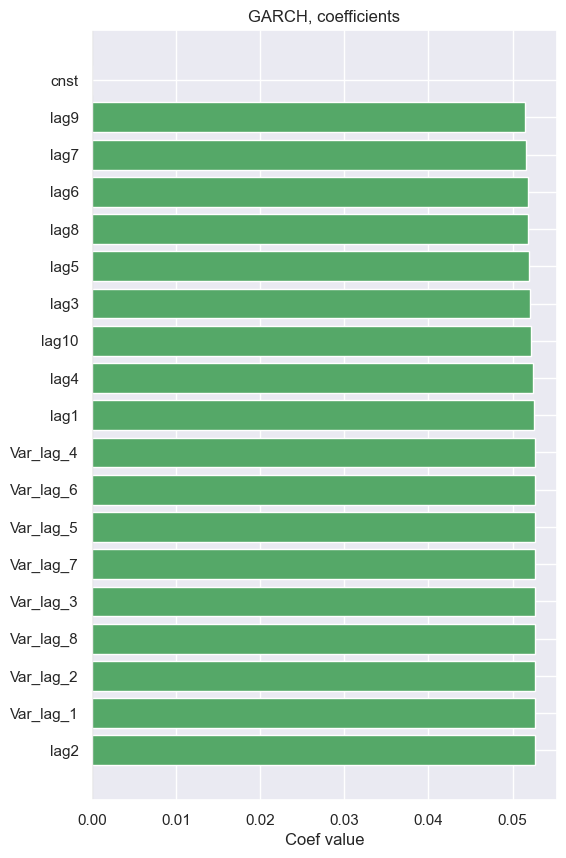

In [19]:
plt.figure(figsize=(6, 10))
colors = ['g' if c > 0 else 'r' for c in garch_coef['coef value']]
plt.barh(y=garch_coef.index, width=garch_coef['coef value'], color=colors)
plt.title("GARCH, coefficients")
plt.axvline(0, color='grey', linewidth=0.8)
plt.xlabel('Coef value')

In [20]:
# GARCH - auto differential

3. Choosing model

In [21]:
# Compare model
comparision = {
    'baseline'  : [bl_loss]*2 + [np.nan] * len(train_loss_list1 + val_loss_list1),
    'ARCH - lin': [np.asarray(train_loss_list1).mean(), np.asarray(val_loss_list1).mean()] + train_loss_list1 + val_loss_list1,
    'ARCH - log': [np.asarray(train_loss_list2).mean(), np.asarray(val_loss_list2).mean()] + train_loss_list2 + val_loss_list2,
    'ARCH - hybrid': [np.asarray(train_loss_list3).mean(), np.asarray(val_loss_list3).mean()] + train_loss_list3 + val_loss_list3,
    'GARCH': [np.asarray(train_loss_list4).mean(), np.asarray(val_loss_list4).mean()] + train_loss_list4 + val_loss_list4,
    }

metrics = ['avg_train_qlike', 'avg_val_qlike'] + [f'fold_{f+1}_train_qlike' for f in range(len(train_loss_list1))] + [f'fold_{f+1}_val_qlike' for f in range(len(val_loss_list1))]

comparision_df = pd.DataFrame(comparision, index=metrics)
comparision_df.T.sort_values(by=['avg_train_qlike', 'avg_val_qlike'], ascending=True)

,avg_train_qlike,avg_val_qlike,fold_1_train_qlike,fold_2_train_qlike,fold_3_train_qlike,fold_1_val_qlike,fold_2_val_qlike,fold_3_val_qlike
ARCH - lin,1.840581,0.983511,1.719449,1.637592,2.164702,0.297414,0.339707,2.313412
ARCH - hybrid,1.937001,0.855605,1.861037,1.742642,2.207323,0.000451,0.284596,2.281766
ARCH - log,2.067492,1.323313,2.031352,1.732377,2.438748,0.915353,0.445214,2.609372
GARCH,2.146028,0.725228,1.734022,1.627001,3.077060,0.075619,0.470083,1.629980
baseline,3.042921,3.042921,NaN,NaN,NaN,NaN,NaN,NaN


- ARCH - hybrid has overall better performace than other, and close performace with ARCH-lin but way better score for fold 1 validation => Champion model.

4. Retrain model

In [22]:
# Configs
q = 10
lr = 0.0001
epochs = 500

In [23]:
fin_vol_model = ARCH_MD(q, epochs, lr, log='hybrid')
fin_vol_model.fit(df['return'].iloc[:3500], df['return'].iloc[3500:], verbose=0, stopstep=5)

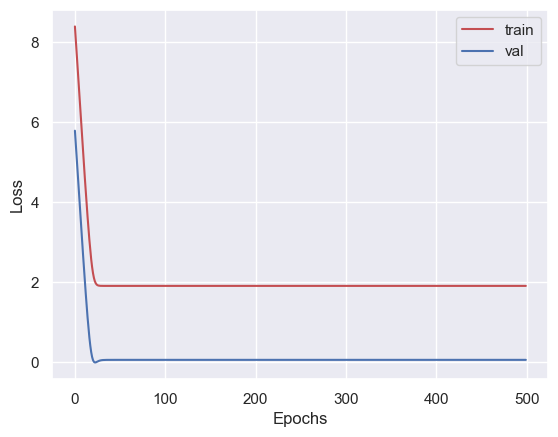

In [24]:
plt.plot(fin_vol_model.train_loss, color='r', label='train')
plt.plot(fin_vol_model.val_loss, color='b', label='val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Steep learning curve, converge quickly.

In [25]:
fin_coef = fin_vol_model.summary()

Text(0.5, 0, 'Coef value')

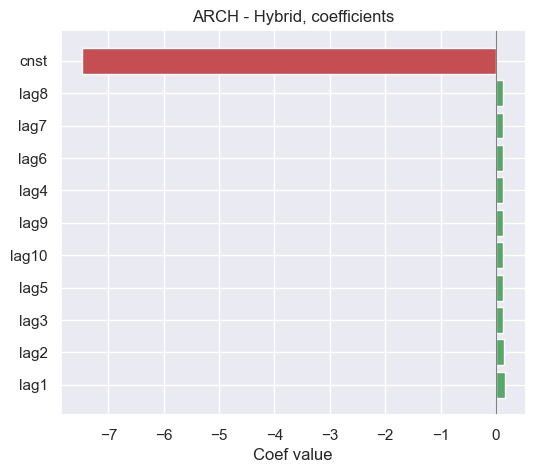

In [26]:
plt.figure(figsize=(6, 5))
colors = ['g' if c > 0 else 'r' for c in fin_coef['coef value']]
plt.barh(y=fin_coef.index, width=fin_coef['coef value'], color=colors)
plt.title("ARCH - Hybrid, coefficients")
plt.axvline(0, color='grey', linewidth=0.8)
plt.xlabel('Coef value')

Text(0.5, 0, 'Coef value')

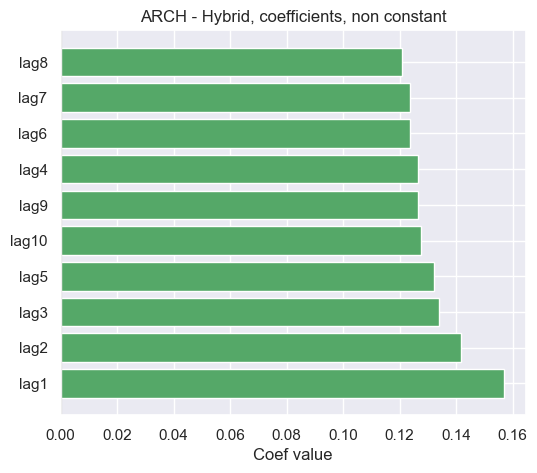

In [27]:
plt.figure(figsize=(6, 5))
fin_coef = fin_coef[fin_coef > 0]
colors = ['g' if c > 0 else 'r' for c in fin_coef['coef value']]
plt.barh(y=fin_coef.index, width=fin_coef['coef value'], color=colors)
plt.title("ARCH - Hybrid, coefficients, non constant")
plt.axvline(0, color='grey', linewidth=0.8)
plt.xlabel('Coef value')

Very low constant value with positive adjust from price. The model does capture the volatility impact, with very low intercept indicating the volatility highly impacted by the past shock.

#### **VII. Decision bot**

In [45]:
# Config
cash_original = 3000
number_of_shares_original = 0
p_price = 30

discount_rate = 0.4
risk_adverse_factor = 1.2 # Risk adverse person
risk_adverse_factor_2 = 0.8 # Risk tolerance person

explore_rate = 0.7
decay_rate = 0.998 # At epoch 340, explore rate is around 0.5 => Moving to exploit more than explore

lr = 0.03
epochs = 10000
batch_size = 32 # Change behavior after 1 month

action_list = [1, 5, 10, -1, -5, -10, 0] # 0 mean hold, 1 at index 0 to make sure non random at initialization make some action

In [29]:
# Predict volatility
var_estimate = fin_vol_model.predict(df['return'].iloc[3000:], include_past_estimate=True)[:-1].reset_index(drop=True)
consider_df = df.iloc[3000:].reset_index(drop=True)

In [30]:
# Decision model on price and volatility
decision = price_volatility(risk_adverse_factor, cash_original, p_price, number_of_shares_original, discount_rate, explore_rate, decay_rate, lr, epochs, action_list, batch_size=batch_size)
decision.fit(consider_df, var_estimate,verbose=0)

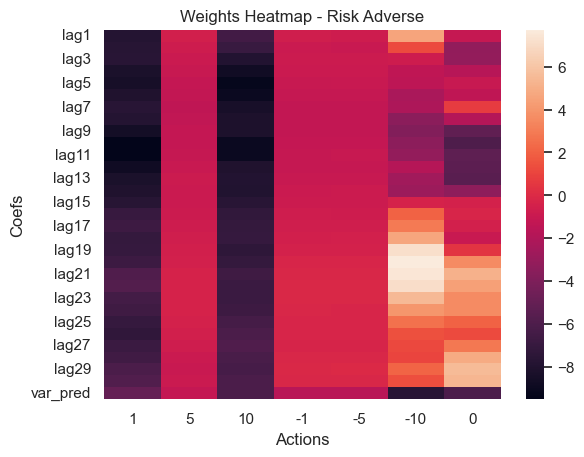

In [31]:
sns.heatmap(decision.W.rename(columns = dict(zip([i for i in range(len(action_list))], action_list)))/1e4)
plt.title('Weights Heatmap - Risk Adverse')
plt.xlabel('Actions')
plt.ylabel('Coefs')
plt.show()

In [33]:
decision_TC = decision.final_capital_list
decision_cash = decision.cash_list
decision_shares = decision.shares_list

Text(0, 0.5, 'Total final capital')

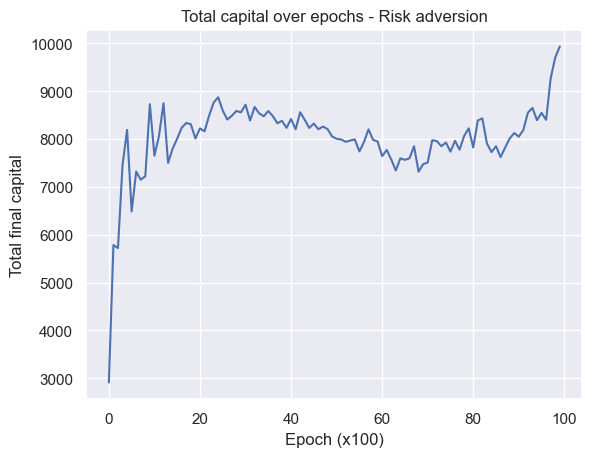

In [34]:
plt.plot(decision_TC[::100])
plt.title('Total capital over epochs - Risk adversion')
plt.xlabel('Epoch (x100)')
plt.ylabel('Total final capital')

Text(0, 0.5, 'Final cash (thousand VND)')

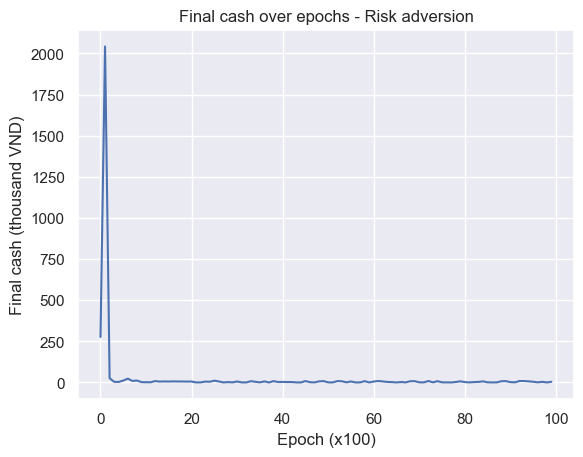

In [35]:
plt.plot(decision_cash[::100])
plt.title('Final cash over epochs - Risk adversion')
plt.xlabel('Epoch (x100)')
plt.ylabel('Final cash (thousand VND)')

Text(0, 0.5, 'Final shares')

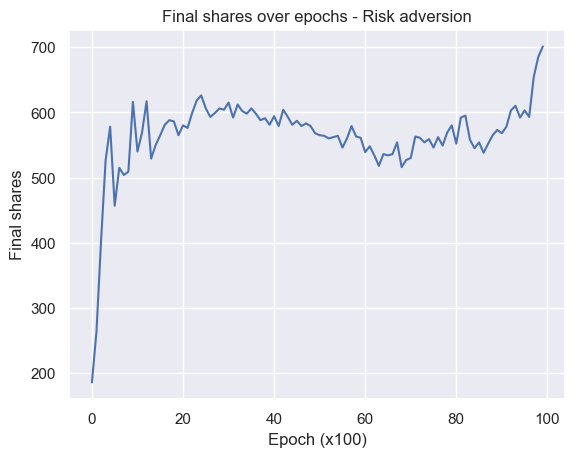

In [36]:
plt.plot(decision_shares[::100])
plt.title('Final shares over epochs - Risk adversion')
plt.xlabel('Epoch (x100)')
plt.ylabel('Final shares')

In [37]:
# Decision model on price and volatility
decision2 = price_volatility(risk_adverse_factor_2, cash_original, p_price, number_of_shares_original, discount_rate, explore_rate, decay_rate, lr, epochs, action_list, batch_size=batch_size)
decision2.fit(consider_df, var_estimate, verbose=0)

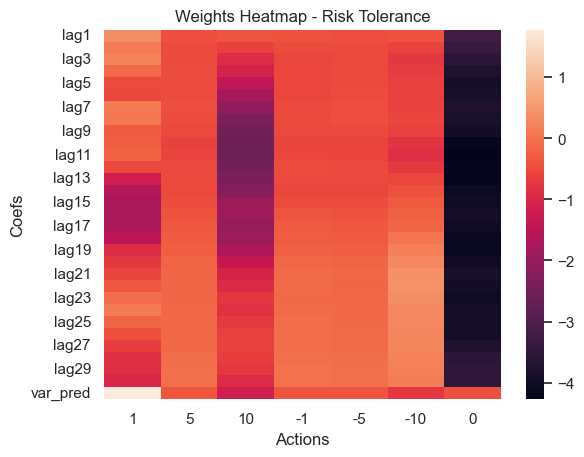

In [38]:
sns.heatmap(decision2.W.rename(columns = dict(zip([i for i in range(len(action_list))], action_list)))/1e4)
plt.title('Weights Heatmap - Risk Tolerance')
plt.xlabel('Actions')
plt.ylabel('Coefs')
plt.show()

In [41]:
decision_TC2 = decision2.final_capital_list
decision_cash2 = decision2.cash_list
decision_shares2 = decision2.shares_list

Text(0, 0.5, 'Total final capital')

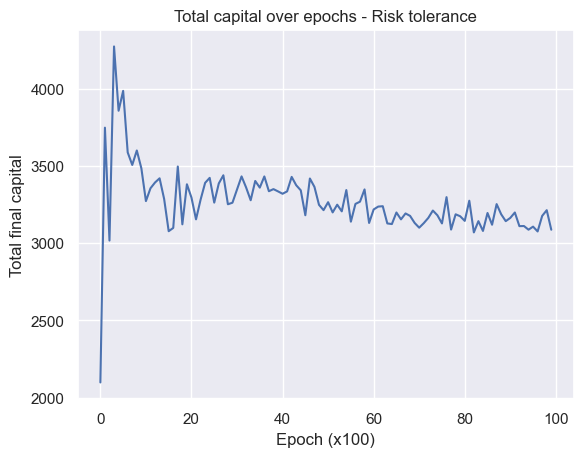

In [42]:
plt.plot(decision_TC2[::100])
plt.title('Total capital over epochs - Risk tolerance')
plt.xlabel('Epoch (x100)')
plt.ylabel('Total final capital')

Text(0, 0.5, 'Final cash (thousand VND)')

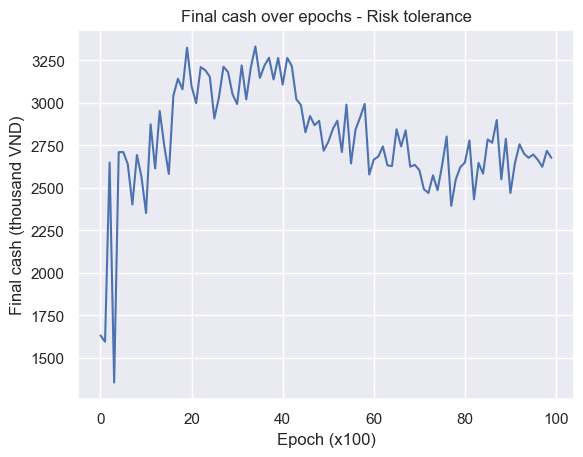

In [43]:
plt.plot(decision_cash2[::100])
plt.title('Final cash over epochs - Risk tolerance')
plt.xlabel('Epoch (x100)')
plt.ylabel('Final cash (thousand VND)')

Text(0, 0.5, 'Final shares')

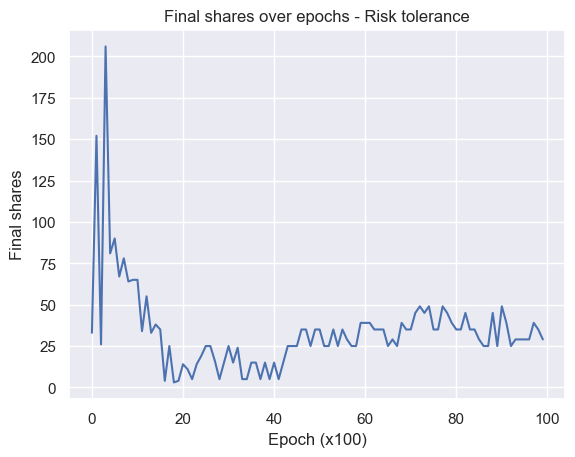

In [44]:
plt.plot(decision_shares2[::100])
plt.title('Final shares over epochs - Risk tolerance')
plt.xlabel('Epoch (x100)')
plt.ylabel('Final shares')